In [1]:
## Set Python - Spark environment.
import os
import sys
#Setting the path for Spark
# os.environ['SPARK_HOME'] = "/home/Kunal/Downloads/spark-2.4.7-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.7,org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.7 pyspark-shell'
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
# !pip install pyarrow==0.14

In [2]:
# !pip install fbprophet

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

Importing plotly failed. Interactive plots will not work.


In [4]:
## Create SparkContext, SparkSession
from pyspark.sql import *
import pyspark
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
# from os.path import join, abspath
# warehouse_location = '/user/hive/warehouse'

In [5]:
# #setting configuration
# conf = SparkConf().setAppName("Python_Spark_PHD_Complete").setMaster('local')
# sc = SparkContext(conf=conf)
# # spark = SparkSession(sc)
# spark = SparkSession \
#             .builder \
#             .appName("Python Spark Multiple Time Series") \
#             .config("spark.sql.catalogImplementation=hive").enableHiveSupport() \
#             .getOrCreate()
#setting configuration
conf = SparkConf().setAppName("Python_Spark_PHD_Complete").setMaster('yarn-client').set("spark.driver.memory","5g")
sc = SparkContext(conf=conf)
# sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","8g").set("spark.executor.memory", '8g').set('spark.executor.cores', 4))
sc.setLogLevel("ERROR")
# spark = SparkSession(sc)
spark = SparkSession \
            .builder \
            .appName("Python Spark SQL basic example") \
            .config("spark.sql.catalogImplementation=hive").enableHiveSupport() \
            .getOrCreate()

In [6]:
#Reading household dataset from hadoop cluster
sales_weekly_df=spark.read.csv("hdfs://localhost:9000//user/kunal/weekly_sales_data.csv",header=True)

In [7]:
#show rows
sales_weekly_df.show()

+---------+--------+-----------+
|     date|store_id|      sales|
+---------+--------+-----------+
| 1/6/2019|      25|736657.2267|
| 1/6/2019|      26|     233711|
| 1/6/2019|      28|692156.3794|
| 1/6/2019|      29|   213706.8|
| 1/6/2019|      30|     266455|
| 1/6/2019|      31|837342.8156|
| 1/6/2019|      35|   201013.6|
| 1/6/2019|      38|  242397.03|
| 1/6/2019|      41|   244189.4|
| 1/6/2019|      44|   164553.5|
|1/13/2019|      25|696457.1717|
|1/13/2019|      26|  261136.45|
|1/13/2019|      28|  787359.03|
|1/13/2019|      29|     279218|
|1/13/2019|      30|  252519.59|
|1/13/2019|      31|836604.5717|
|1/13/2019|      35| 277550.185|
|1/13/2019|      38| 215895.275|
|1/13/2019|      41|   231992.5|
|1/13/2019|      44|     134188|
+---------+--------+-----------+
only showing top 20 rows



In [8]:
#Convert Date column into time stamp format
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType,TimestampType
func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), TimestampType())
spark_df = sales_weekly_df.withColumn('Date', func(col('date')))

In [9]:
spark_df.show()

+-------------------+--------+-----------+
|               Date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|     233711|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|     266455|
|2019-01-06 00:00:00|      31|837342.8156|
|2019-01-06 00:00:00|      35|   201013.6|
|2019-01-06 00:00:00|      38|  242397.03|
|2019-01-06 00:00:00|      41|   244189.4|
|2019-01-06 00:00:00|      44|   164553.5|
|2019-01-13 00:00:00|      25|696457.1717|
|2019-01-13 00:00:00|      26|  261136.45|
|2019-01-13 00:00:00|      28|  787359.03|
|2019-01-13 00:00:00|      29|     279218|
|2019-01-13 00:00:00|      30|  252519.59|
|2019-01-13 00:00:00|      31|836604.5717|
|2019-01-13 00:00:00|      35| 277550.185|
|2019-01-13 00:00:00|      38| 215895.275|
|2019-01-13 00:00:00|      41|   231992.5|
|2019-01-13 00:00:00|      44|     134188|
+----------

In [10]:
sdf=spark_df.select("Date","store_id","sales")
sdf.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- store_id: string (nullable = true)
 |-- sales: string (nullable = true)



In [11]:
sdf=sdf.withColumn('sales',sdf['sales'].cast('double'))

In [12]:
sdf=sdf.withColumn('store_id',sdf['store_id'].cast('double'))

In [13]:
sdf.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- store_id: double (nullable = true)
 |-- sales: double (nullable = true)



In [14]:
sdf.count()

500

In [15]:
sdf.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|    29.0|             50|
|    44.0|             50|
|    35.0|             50|
|    25.0|             50|
|    41.0|             50|
|    31.0|             50|
|    28.0|             50|
|    38.0|             50|
|    30.0|             50|
|    26.0|             50|
+--------+---------------+



In [16]:
sdf.createOrReplaceTempView("sales")

In [17]:
spark.sql("select store_id, count(*) from sales group by store_id order by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|    25.0|      50|
|    26.0|      50|
|    28.0|      50|
|    29.0|      50|
|    30.0|      50|
|    31.0|      50|
|    35.0|      50|
|    38.0|      50|
|    41.0|      50|
|    44.0|      50|
+--------+--------+



In [18]:
spark.sql('SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds').show()

+--------+-------------------+-----------+
|store_id|                 ds|          y|
+--------+-------------------+-----------+
|    25.0|2019-01-06 00:00:00|736657.2267|
|    25.0|2019-01-13 00:00:00|696457.1717|
|    25.0|2019-01-20 00:00:00| 996876.875|
|    25.0|2019-01-27 00:00:00| 1029737.05|
|    25.0|2019-02-03 00:00:00|1072873.705|
|    25.0|2019-02-10 00:00:00|880462.4681|
|    25.0|2019-02-17 00:00:00| 1088756.78|
|    25.0|2019-02-24 00:00:00|1266928.313|
|    25.0|2019-03-03 00:00:00|907510.1217|
|    25.0|2019-03-10 00:00:00|747920.9824|
|    25.0|2019-03-17 00:00:00|904750.3158|
|    25.0|2019-03-24 00:00:00|1069857.589|
|    25.0|2019-03-31 00:00:00|1195574.314|
|    25.0|2019-04-07 00:00:00|834911.3333|
|    25.0|2019-04-14 00:00:00|788777.4167|
|    25.0|2019-04-21 00:00:00|849603.4333|
|    25.0|2019-04-28 00:00:00| 965521.165|
|    25.0|2019-05-05 00:00:00|1045632.688|
|    25.0|2019-05-12 00:00:00| 587768.245|
|    25.0|2019-05-19 00:00:00|806767.5946|
+--------+-

In [19]:
sdf.rdd.getNumPartitions()

1

In [20]:
sql='SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds'

In [21]:
store_part = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['store_id'])).cache()

In [22]:
store_part

DataFrame[store_id: double, ds: timestamp, y: double]

In [23]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#55, ds#126, y#127]
   +- InMemoryRelation [store_id#55, ds#126, y#127], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#55, 2)
            +- *(4) Sort [store_id#55 ASC NULLS FIRST, ds#126 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#55 ASC NULLS FIRST, ds#126 ASC NULLS FIRST, 200)
                  +- *(3) HashAggregate(keys=[store_id#55, date#30], functions=[sum(sales#51)])
                     +- Exchange hashpartitioning(store_id#55, date#30, 200)
                        +- *(2) HashAggregate(keys=[store_id#55, date#30], functions=[partial_sum(sales#51)])
                           +- *(2) Project [pythonUDF0#134 AS Date#30, cast(store_id#11 as double) AS store_id#55, cast(sales#12 as double) AS sales#51]
                              +- BatchEvalPython [<lambda>(date#10)], [date#10, store_id#11, sales#12, pythonUDF0#134]
                           

In [24]:
result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('store_id',IntegerType()),
  StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])

In [25]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( store_pd ):

  model = Prophet(interval_width=0.95,seasonality_mode = 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)

  model.fit( store_pd )

  future_pd = model.make_future_dataframe(
    periods=5, 
    freq='w'
    )
  
  forecast_pd = model.predict( future_pd )  
  
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  st_pd = store_pd[['ds','store_id','y']].set_index('ds')
  
  results_pd = f_pd.join( st_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  results_pd['store_id'] = store_pd['store_id'].iloc[0]

  return results_pd[ ['ds', 'store_id','y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

In [26]:
from pyspark.sql.functions import current_date

results = (
  store_part
    .groupBy('store_id')
    .apply(forecast_sales)
    .withColumn('training_date', current_date() )
    )

In [27]:
results.cache()

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [28]:
results.printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- y: double (nullable = true)
 |-- yhat: double (nullable = true)
 |-- yhat_upper: double (nullable = true)
 |-- yhat_lower: double (nullable = true)
 |-- training_date: date (nullable = false)



In [29]:
results.explain()

== Physical Plan ==
InMemoryTableScan [ds#173, store_id#174, y#175, yhat#176, yhat_upper#177, yhat_lower#178, training_date#185]
   +- InMemoryRelation [ds#173, store_id#174, y#175, yhat#176, yhat_upper#177, yhat_lower#178, training_date#185], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(2) Project [ds#173, store_id#174, y#175, yhat#176, yhat_upper#177, yhat_lower#178, 18826 AS training_date#185]
            +- FlatMapGroupsInPandas [store_id#55], forecast_sales(store_id#55, ds#126, y#127), [ds#173, store_id#174, y#175, yhat#176, yhat_upper#177, yhat_lower#178]
               +- *(1) Sort [store_id#55 ASC NULLS FIRST], false, 0
                  +- InMemoryTableScan [store_id#55, store_id#55, ds#126, y#127]
                        +- InMemoryRelation [store_id#55, ds#126, y#127], StorageLevel(disk, memory, deserialized, 1 replicas)
                              +- Exchange hashpartitioning(store_id#55, 2)
                                 +- *(4) Sort [store_id#55 

In [30]:
results.coalesce(1)

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [31]:
# results.count()
results=results.filter("store_id is not null")

In [32]:
results.printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- y: double (nullable = true)
 |-- yhat: double (nullable = true)
 |-- yhat_upper: double (nullable = true)
 |-- yhat_lower: double (nullable = true)
 |-- training_date: date (nullable = false)



In [33]:
df_results=results.withColumn("training_date",results["training_date"].cast(TimestampType()))

In [34]:
df_results.printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- y: double (nullable = true)
 |-- yhat: double (nullable = true)
 |-- yhat_upper: double (nullable = true)
 |-- yhat_lower: double (nullable = true)
 |-- training_date: timestamp (nullable = false)



In [35]:
df_results.show()

+-------------------+--------+-----------+------------------+------------------+------------------+-------------------+
|                 ds|store_id|          y|              yhat|        yhat_upper|        yhat_lower|      training_date|
+-------------------+--------+-----------+------------------+------------------+------------------+-------------------+
|2019-01-06 00:00:00|      25|736657.2267| 712575.0694034342| 951145.1714429691|481264.82516048197|2021-07-18 00:00:00|
|2019-01-13 00:00:00|      25|696457.1717| 743751.7568928569| 974123.3020284316| 504054.6607367446|2021-07-18 00:00:00|
|2019-01-20 00:00:00|      25| 996876.875| 972909.8778010788|1215014.4092873293|  759465.238607354|2021-07-18 00:00:00|
|2019-01-27 00:00:00|      25| 1029737.05|1034447.5557582717| 1264969.198907835| 811822.7152067492|2021-07-18 00:00:00|
|2019-02-03 00:00:00|      25|1072873.705| 986365.7266742919|1208138.3833476666| 754330.1094141544|2021-07-18 00:00:00|
|2019-02-10 00:00:00|      25|880462.468

In [36]:
df_results.createOrReplaceTempView('forecasted')

In [37]:
spark.sql("select store_id, count(*) from forecasted group by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      55|
|      28|      55|
|      26|      55|
|      44|      55|
|      41|      55|
|      35|      55|
|      38|      55|
|      25|      55|
|      29|      55|
|      30|      55|
+--------+--------+



In [38]:
final_df = df_results.toPandas()

In [39]:
final_df

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25,7.366572e+05,7.125751e+05,9.511452e+05,481264.825160,2021-07-18
1,2019-01-13,25,6.964572e+05,7.437518e+05,9.741233e+05,504054.660737,2021-07-18
2,2019-01-20,25,9.968769e+05,9.729099e+05,1.215014e+06,759465.238607,2021-07-18
3,2019-01-27,25,1.029737e+06,1.034448e+06,1.264969e+06,811822.715207,2021-07-18
4,2019-02-03,25,1.072874e+06,9.863657e+05,1.208138e+06,754330.109414,2021-07-18
...,...,...,...,...,...,...,...
545,2019-12-22,44,NaN,6.265474e+04,1.241497e+05,-1930.359205,2021-07-18
546,2019-12-29,44,NaN,2.657442e+04,9.034891e+04,-34688.853747,2021-07-18
547,2020-01-05,44,NaN,8.801264e+03,7.213202e+04,-53411.941180,2021-07-18
548,2020-01-12,44,NaN,4.665900e+03,6.847400e+04,-56652.550310,2021-07-18


In [40]:
final_df=final_df.set_index('ds')

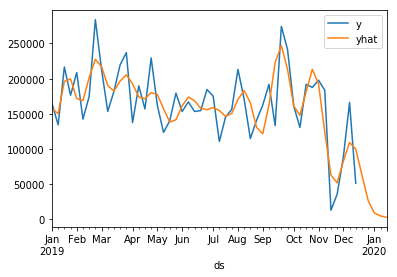

In [41]:
final_df.query('store_id==44')[['y','yhat']].plot()

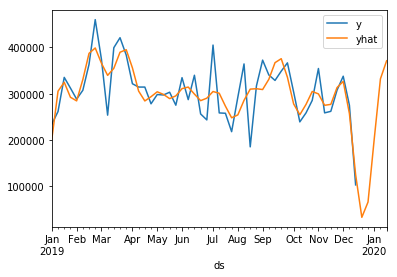

In [42]:
final_df.query('store_id==26')[['y','yhat']].plot()

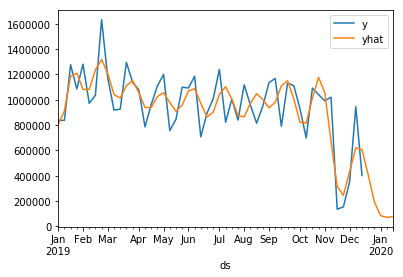

In [43]:
final_df.query('store_id==31')[['y','yhat']].plot()

In [44]:
#END